In [68]:
import pandas as pd
import numpy as np
import os
import io
import logging
import ast
from collections import Counter

from tensorflow import keras

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from skmultilearn.model_selection.measures import get_combination_wise_output_matrix
from skmultilearn.model_selection import iterative_train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Embedding, Conv1D, MaxPooling1D, Flatten, GlobalMaxPool1D, Dropout, SpatialDropout1D, GlobalAveragePooling1D, LSTM, Bidirectional
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from keras.losses import binary_crossentropy
from keras.optimizers import Adam
from keras import backend as K
import kerastuner as kt

In [69]:
keras.__version__

'2.4.0'

In [70]:
datasets = "/datasets/"
path_datasets = "..{0}".format(datasets)
path_model = "../model/"
path_best_models = "../model/best_models/"

PATH_CORPUS = "../corpus/"
PATH_TOKENIZER = "../tokenizer/"
GLOVE_DIR = "../glove/"
TEXT_DICT_NAME = "path_to_text.json"

LOG_FILE_NAME = "../logging/capability_model.log"
TENSORBOARD_LOG = "../logging/tensorboard/"

MAX_SEQUENCE_LENGTH = 180
MAX_WORDS = 5000

In [71]:
logger = logging.getLogger('root')
FORMAT = "[%(asctime)s %(filename)s:%(lineno)s - %(funcName)s() ] %(message)s"
logging.basicConfig(format=FORMAT, filename=LOG_FILE_NAME)
logger.setLevel(logging.DEBUG)

In [72]:
ds_text = pd.read_csv(path_datasets + 'ds_text.csv', converters={"Capabilities": lambda x: ast.literal_eval(x)})
df_capability = pd.read_csv(path_datasets + 'df_capability.csv')

In [73]:
ds_text.shape

(96, 3)

In [74]:
ds_text.head()

File  \
0      P7_QE(2010)1004_EN.docx   
1  EMPL_AD(2016)583967_EN.docx   
2  P7_TA-PROV(2011)0235_EN.pdf   
3  IMCO_PR(2020)650478_EN.docx   
4      business_secrets_en.pdf   

                                                Text  \
0  written question martin ehrenhaus commiss subj...   
1  commiss empl committe employ social affair com...   
2  prov small busi act review the european parlia...   
3  commiss imco committe intern market consum pro...   
4  annex guidanc confidenti claim commiss antitru...   

                                        Capabilities  
0  [Digital policy, EU policymaking, Digital tech...  
1  [EU policymaking, Digital innovation, Digital ...  
2  [Business Continuity Planning, Legislation and...  
3  [Strategy and Planning, Business Continuity Pl...  
4                      [Legal support, Legal Advice]

In [75]:
df_capability.shape

(321, 1)

### MultiLabel Binarizer

In [76]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(ds_text['Capabilities'])
labels = multilabel_binarizer.classes_

In [77]:
labels

array(['Administration coherence', 'Administrative Law',
       'Business Continuity Planning', 'Digital Services ',
       'Digital Strategy', 'Digital innovation', 'Digital policy',
       'Digital technology', 'EU policymaking',
       'Health and safety standards', 'Human Resource Governance',
       'ICT Service delivery', 'Legal Advice', 'Legal support',
       'Legislation and standards definition',
       'Legislation and standards enforcement', 'Security control',
       'Strategy and Planning', 'Tools, platforms and services',
       'Workforce Capability Development'], dtype=object)

In [78]:
len(labels)

20

In [79]:
#Output format. Just for representation purposes!
ds_text_labels = pd.DataFrame(multilabel_binarizer.fit_transform(ds_text['Capabilities']), columns=multilabel_binarizer.classes_)

In [14]:
ds_text_labels.head()

Administration coherence  Administrative Law  Business Continuity Planning  \
0                         0                   0                             0   
1                         0                   0                             0   
2                         0                   0                             1   
3                         0                   0                             1   
4                         0                   0                             0   

   Digital Services   Digital Strategy  Digital innovation  Digital policy  \
0                  0                 0                   0               1   
1                  0                 0                   1               0   
2                  0                 0                   0               0   
3                  0                 0                   0               0   
4                  0                 0                   0               0   

   Digital technology  EU policymaking  Health and safety standards  \
0                   1                1                            0   
1                   1                1                            0   
2                   0                1                            0   
3                   0                0                            0   
4                   0                0                            0   

   Human Resource Governance  ICT Service delivery  Legal Advice  \
0                          1                     1             0   
1                          0                     0             0   
2                          0                     0             0   
3                          0                     0             0   
4                          0                     0             1   

   Legal support  Legislation and standards definition  \
0              0                                     0   
1              0                                     0   
2              0                                     0   
3              0                                     0   
4              1                                     0   

   Legislation and standards enforcement  Security control  \
0                                      0                 1   
1                                      0                 0   
2                                      1                 0   
3                                      1                 0   
4                                      0                 0   

   Strategy and Planning  Tools, platforms and services  \
0                      0                              1   
1                      0                              1   
2                      0                              0   
3                      1                              0   
4                      0                              0   

   Workforce Capability Development  
0                                 0  
1                                 0  
2                                 0  
3                                 1  
4                                 0

### Tokenizer

In [80]:
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(ds_text['Text'])

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 11732 unique tokens.


In [17]:
#To persist the Tokenizer.
tokenizer = tokenizer.to_json()
with open(PATH_TOKENIZER + 'tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer, ensure_ascii=False))

In [81]:
def get_features(text_series):
    '''
        To transform text data into feature_vectors suitable for modeling.
        Tokenizer must be available.
    '''
    sequences = tokenizer.texts_to_sequences(text_series)
    return pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

### Most common capabilities

In [82]:
grouped_capabilities = df_capability.groupby("Capability").size().reset_index(name='count')
grouped_capabilities['Capability'].describe()

count                                          116
unique                                         116
top       Inter-institutional information exchange
freq                                             1
Name: Capability, dtype: object

In [83]:
num_labels = 116
most_common_capabilities = grouped_capabilities.nlargest(num_labels, columns="count")
df_capability['Capability'] = df_capability['Capability'].apply(lambda x : x if x in most_common_capabilities['Capability'].values else None)
df_capability.dropna()

Capability
0                   Digital policy
1                  EU policymaking
2               Digital technology
3    Tools, platforms and services
4        Human Resource Governance
..                             ...
316             Administrative Law
317             Digital technology
318  Tools, platforms and services
319           ICT Service delivery
320                EU policymaking

[321 rows x 1 columns]

### Deriving class weights

In [84]:
most_common_capabilities['class_weight'] = len(df_capability) / most_common_capabilities['count']
most_common_capabilities = most_common_capabilities.reset_index(drop=True)

In [85]:
class_weight = {}
for index, label in enumerate(labels):
    class_weight[index] = most_common_capabilities[most_common_capabilities['Capability'] == label]['class_weight'].values[0]

In [33]:
class_weight

{0: 160.5,
 1: 160.5,
 2: 80.25,
 3: 321.0,
 4: 321.0,
 5: 32.1,
 6: 22.928571428571427,
 7: 16.05,
 8: 14.590909090909092,
 9: 160.5,
 10: 80.25,
 11: 20.0625,
 12: 64.2,
 13: 64.2,
 14: 53.5,
 15: 80.25,
 16: 80.25,
 17: 160.5,
 18: 10.03125,
 19: 160.5}

Class weights were tested in the training process in terms of loss due to class imbalancing. Suitable for multi-class, but not for multi-label classification.

### Train Test Split

In [86]:
def train_test_ds_split(texts, labels, test_size=0.3, random_state=666):
    '''
        Split the data into training and testing datasets.
    '''
    
    X = get_features(texts)
    Y = multilabel_binarizer.transform(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    X_file, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, Y_train, Y_test

In [119]:
def train_val_split_multilearn(texts, labels, test_size=0.5, random_state=122):
    '''
        Split the data into training and validation datasets using the multilearn approach.
    '''
    X = get_features(texts)
    Y = multilabel_binarizer.transform(labels)
    
    x_train, y_train, x_val, y_val = iterative_train_test_split(X, Y, test_size=test_size)
    
    return x_train, y_train, x_val, y_val

In [120]:
x_train, y_train, x_val, y_val = train_val_split_multilearn(ds_text['Text'], ds_text['Capabilities'], test_size=0.5,  random_state=122)

In [121]:
pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_val, order=2) for combination in row)
}).T.fillna(0.0)

(6, 18)  (8, 8)  (7, 7)  (6, 8)  (6, 7)  (18, 18)  (6, 6)  (8, 18)  \
train       17      27      25      17      12        29      17       20   
test        18      27      25      18      13        26      18       20   

       (7, 18)  (7, 8)  ...  (1, 11)  (1, 1)  (1, 7)  (4, 4)  (3, 3)  (3, 4)  \
train       24      15  ...        3       3       3       1       1       1   
test        21      15  ...        2       2       2       1       1       1   

       (7, 10)  (7, 16)  (8, 15)  (2, 8)  
train        2        2        2       2  
test         3        3        3       3  

[2 rows x 62 columns]

Due to the small number of documents included in the dataset, the testing dataset is used for validation purposes, i.e. hyper parameters optimization. A testing dataset will be derived and used at a later stage.

## Building an ANN Model

### Glove Embedding

In [90]:
embeddings_index = {}

f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [91]:
EMBEDDING_DIM = 100

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### LSTM Model

In [164]:
input_layer = Input(shape=(MAX_SEQUENCE_LENGTH,))

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                            weights=[embedding_matrix], mask_zero=True,
                            trainable=True)(input_layer)

decision_layers = SpatialDropout1D(0.2)(embedding_layer)

#with Bidirectional layer, the cell state goes in both directions
decision_layers = Bidirectional(LSTM(MAX_SEQUENCE_LENGTH, dropout=0.2, recurrent_dropout=0.2))(decision_layers)
decision_layers = Dense(1000, activation='tanh')(decision_layers)
decision_layers = Dropout(0.2)(decision_layers)
decision_layers = Dense(20, activation='sigmoid')(decision_layers)#20 corresponds with the number of labels taken into account

capability_model = Model(inputs=input_layer, outputs=decision_layers)

capability_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 180)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 180, 100)          1173300   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 180, 100)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 360)               404640    
_________________________________________________________________
dense_12 (Dense)             (None, 1000)              361000    
_________________________________________________________________
dropout_6 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_13 (Dense)             (None, 20)                2002

## Callbacks

In [145]:
model_file_template = "capability_model.{epoch:02d}-loss.{val_loss:.2f}-val_auc.{val_auc:.2f}.hdf5"

In [93]:
#model_file_template = "capability_model.{epoch:02d}-loss.{val_loss:.2f}-val_auc.{val_binary_accuracy:.2f}.hdf5"

In [166]:
checkpointer = ModelCheckpoint(filepath=path_model + model_file_template, monitor='val_auc', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_auc', min_delta=0.001, patience=10, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_auc', factor=0.6, patience=5, verbose=0, mode='max', min_delta=0.001)
tensorboard = TensorBoard(log_dir=TENSORBOARD_LOG, histogram_freq=0, write_graph=False, write_images=True, update_freq="epoch")

callbacks = [checkpointer, early_stopping, reduce_lr, tensorboard]

In [95]:
#checkpointer = ModelCheckpoint(filepath=path_model + model_file_template, monitor='val_binary_accuracy', save_best_only=False, mode='max')
#early_stopping = EarlyStopping(monitor='val_binary_accuracy', min_delta=0.001, patience=10, mode='max')
#reduce_lr = ReduceLROnPlateau(monitor='val_binary_accuracy', factor=0.6, patience=5, verbose=0, mode='max', min_delta=0.001)
#tensorboard = TensorBoard(log_dir=TENSORBOARD_LOG, histogram_freq=0, write_graph=False, write_images=True, update_freq="epoch")

#callbacks = [checkpointer, early_stopping, reduce_lr, tensorboard]

## Configure the Model

In [167]:
capability_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', keras.metrics.AUC(
    num_thresholds=3,
    curve="ROC",
    summation_method="majoring",
    name='auc',
    dtype=None,
    thresholds=None,
    multi_label=True,
    label_weights=None)])

In [97]:
#capability_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae', 'binary_accuracy'])

## Train the Model

In [168]:
history = capability_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), batch_size = 16,
                                    verbose=True, callbacks=callbacks)

Epoch 1/20
3/3 [==============================] - 15s 5s/step - loss: 0.6424 - mae: 0.4701 - auc: 0.7713 - val_loss: 0.4437 - val_mae: 0.3294 - val_auc: 0.9860
Epoch 2/20
3/3 [==============================] - 6s 2s/step - loss: 0.4140 - mae: 0.2930 - auc: 0.8963 - val_loss: 0.4320 - val_mae: 0.1877 - val_auc: 0.9910
Epoch 3/20
3/3 [==============================] - 6s 2s/step - loss: 0.3952 - mae: 0.1834 - auc: 0.9035 - val_loss: 0.4073 - val_mae: 0.2007 - val_auc: 0.9667
Epoch 4/20
3/3 [==============================] - 6s 2s/step - loss: 0.3392 - mae: 0.1927 - auc: 0.9200 - val_loss: 0.3835 - val_mae: 0.2329 - val_auc: 0.9745
Epoch 5/20
3/3 [==============================] - 6s 2s/step - loss: 0.3373 - mae: 0.2253 - auc: 0.9266 - val_loss: 0.3879 - val_mae: 0.2463 - val_auc: 0.9778
Epoch 6/20
3/3 [==============================] - 6s 2s/step - loss: 0.3334 - mae: 0.2262 - auc: 0.9415 - val_loss: 0.3836 - val_mae: 0.2350 - val_auc: 0.9673
Epoch 7/20
3/3 [=============================

In [149]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show

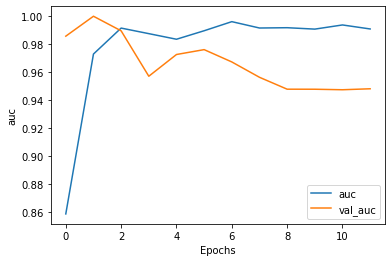

In [154]:
plot_graphs(history, 'auc')

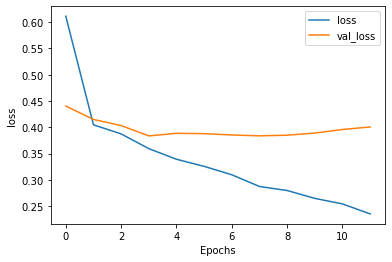

In [155]:
plot_graphs(history, 'loss')

### Model Predictions

In [293]:
#To avoid prediction representations incl. scientific notations.
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

In [135]:
#Sent to Stella.
model = load_model(path_best_models + 'capability_model.02-loss.0.49-val_auc.0.96.hdf5')

In [136]:
#To load the the best model so far. Train_test_split was changed with iterative_train_test_split.
model2 = load_model(path_best_models + 'capability_model.09-loss.0.19-val_auc.0.99.hdf5')

In [137]:
model2.get_config()

{'name': 'model_15',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 180),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'input_24'},
   'name': 'input_24',
   'inbound_nodes': []},
  {'class_name': 'Embedding',
   'config': {'name': 'embedding_22',
    'trainable': True,
    'batch_input_shape': (None, 180),
    'dtype': 'float32',
    'input_dim': 11733,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': True,
    'input_length': 180},
   'name': 'embedding_22',
   'inbound_nodes': [[['input_24', 0, 0, {}]]]},
  {'class_name': 'SpatialDropout1D',
   'config': {'name': 'spatial_dropout1d_15',
    'trainable': True,
    'dtype': 'float32',
    'rate': 0.2,
    'noise_shape': None,
    'seed': None},
   

In [138]:
predictions = model.predict(x_val)

In [139]:
predictions2 = model2.predict(x_val)

In [140]:
def prediction_to_label(prediction):
    '''
        Returns a dictionary in the following form: {'capability': confidence}, sorted in a descending order.
    '''
    prob = [(labels[i], prob) for i, prob in enumerate(prediction.tolist())]
    return dict(sorted(prob, key=lambda kv: kv[1], reverse=True))

In [141]:
prediction_to_label(predictions[0])

{'Tools, platforms and services': 0.9980916976928711,
 'EU policymaking': 0.9965952038764954,
 'Digital policy': 0.9925201535224915,
 'Security control': 0.9771576523780823,
 'Human Resource Governance': 0.976311206817627,
 'ICT Service delivery': 0.9598053693771362,
 'Digital technology': 0.6849145293235779,
 'Administrative Law': 0.013791114091873169,
 'Legislation and standards definition': 0.0113944411277771,
 'Digital innovation': 0.010350525379180908,
 'Legal Advice': 0.0026946663856506348,
 'Legal support': 0.0024946630001068115,
 'Health and safety standards': 0.0002829432487487793,
 'Administration coherence': 0.00027424097061157227,
 'Digital Services ': 0.0002237856388092041,
 'Digital Strategy': 0.00018641352653503418,
 'Legislation and standards enforcement': 0.000116406285087578,
 'Business Continuity Planning': 8.465346036246046e-05,
 'Workforce Capability Development': 7.4491172199486755e-06,
 'Strategy and Planning': 6.7425908127916045e-06}

In [142]:
prediction_to_label(predictions2[0])

{'ICT Service delivery': 0.9986196756362915,
 'Digital policy': 0.9983570575714111,
 'Tools, platforms and services': 0.9981090426445007,
 'EU policymaking': 0.9933371543884277,
 'Security control': 0.9805986881256104,
 'Human Resource Governance': 0.9788436889648438,
 'Digital technology': 0.960105836391449,
 'Administrative Law': 0.015927940607070923,
 'Legislation and standards definition': 0.007372260093688965,
 'Health and safety standards': 0.005108147859573364,
 'Administration coherence': 0.0041595399379730225,
 'Digital Strategy': 0.0023479163646698,
 'Digital innovation': 0.0016950666904449463,
 'Digital Services ': 0.0015294253826141357,
 'Legal Advice': 0.00047713518142700195,
 'Business Continuity Planning': 0.00028228759765625,
 'Legal support': 0.0002797245979309082,
 'Legislation and standards enforcement': 0.00023663043975830078,
 'Workforce Capability Development': 7.740536238998175e-05,
 'Strategy and Planning': 7.090519648045301e-05}